<a href="https://colab.research.google.com/github/Thandriss/DL_labs/blob/main/LSTM_SA%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [2]:
data_path = '/content/kaggle/train.csv'
data = pd.read_csv(data_path)
data = data[['user_review', 'user_suggestion']]
data.head()

,user_review,user_suggestion
0,I'm scared and hearing creepy voices. So I'll...,1
1,"Best game, more better than Sam Pepper's YouTu...",1
2,"A littly iffy on the controls, but once you kn...",1
3,"Great game, fun and colorful and all that.A si...",1
4,Not many games have the cute tag right next to...,1


In [3]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    #text = text.replace('\%','')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = " ".join(filter(lambda x:x[0]!="@", text.split()))
    return text

#Apply the function
data['user_review'] = data['user_review'].apply(lambda x: clean_text(x))

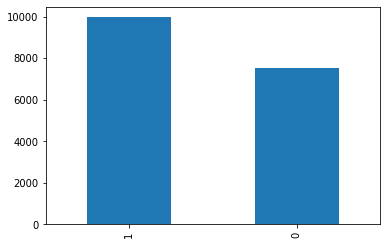

In [4]:
data['user_suggestion'].value_counts().plot(kind='bar')

In [5]:
print(data[ data['user_suggestion'] == 1].size)
print(data[ data['user_suggestion'] == 0].size)

max_length = 2

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['user_review'].values)
X = tokenizer.texts_to_sequences(data['user_review'].values)
X = pad_sequences(X, maxlen=max_length, truncating='pre', padding='pre')

19936
15052


In [15]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='relu'))
model.add(Flatten())
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
print(X.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 128)            256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 2, 128)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
________________________________________________

In [16]:
Y = pd.get_dummies(data['user_suggestion']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11720, 2) (11720, 2)
(5774, 2) (5774, 2)


In [22]:
batch_size = 64
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
184/184 - 4s - loss: 0.5817 - accuracy: 0.6955 - 4s/epoch - 21ms/step
Epoch 2/10
184/184 - 4s - loss: 0.5920 - accuracy: 0.6938 - 4s/epoch - 21ms/step
Epoch 3/10
184/184 - 4s - loss: 0.5699 - accuracy: 0.6997 - 4s/epoch - 21ms/step
Epoch 4/10
184/184 - 4s - loss: 0.5625 - accuracy: 0.7087 - 4s/epoch - 21ms/step
Epoch 5/10
184/184 - 4s - loss: 0.5510 - accuracy: 0.7161 - 4s/epoch - 21ms/step
Epoch 6/10
184/184 - 4s - loss: 0.5672 - accuracy: 0.7122 - 4s/epoch - 21ms/step
Epoch 7/10
184/184 - 4s - loss: 0.5504 - accuracy: 0.7155 - 4s/epoch - 21ms/step
Epoch 8/10
184/184 - 4s - loss: 0.5472 - accuracy: 0.7203 - 4s/epoch - 21ms/step
Epoch 9/10
184/184 - 4s - loss: 0.5328 - accuracy: 0.7218 - 4s/epoch - 20ms/step
Epoch 10/10
184/184 - 4s - loss: 0.5241 - accuracy: 0.7275 - 4s/epoch - 21ms/step


In [23]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

44/44 - 0s - loss: 1.0969 - accuracy: 0.6128 - 148ms/epoch - 3ms/step
score: 1.10
acc: 0.61


In [24]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 13ms/epoch - 13ms/step
1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 14m

In [25]:
twt = ['Meetings: Because none of us is as dumb as all of us.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=2, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

[[  8 395]]
1/1 - 0s - 20ms/epoch - 20ms/step
negative
